# Cavity QED

ZPGenerator is designed to facilitate the construction of more complicated sources from elementary building blocks. A good example of this is found in cavity quantum electrodynamics (QED) where the emission properties of an emitter can be modified by coupling it to an optical cavity mode. By combining a TwoLevelEmitter object with a CavityEmitter object, and adding a Jaynes-Cummings coupling, we obtain a new emitter object that is a textbook example of cavity QED. This new emitter, called the PurcellEmitter, is used to make the PurcellSource that can be constructed using the purcell() class method of the Source class. In this notebook, we will take a look at this source type and what we can learn from it.

For information about the model underlying the purcell() catalogue source, please see [Sources](sources_catalogue.ipynb). For information about how to construct complex systems from scratch, see [Constructing Components](component_construction.ipynb).

## The Purcell source

In [2]:
from zpgenerator import *
import numpy as np
import matplotlib.pyplot as plt

A two-level emitter coupled to a single cavity mode via a Jaynes-Cummings type interaction is available as a catalogue source component using the Source.purcell() class method to construct a PurcellSource object. Let's make a purcell() source and look at the default parameters.

In [3]:
source = Source.purcell()
source.default_parameters

{'coupling': 5.0,
 'area': 3.141592653589793,
 'phase': 0,
 'delay': 0,
 'emitter/resonance': 0.0,
 'emitter/decay': 0.1,
 'emitter/dephasing': 0.0,
 'cavity/resonance': 0.0,
 'cavity/dephasing': 0.0,
 'cavity/decay': 99.99999999999999,
 'efficiency': 1}

By default, we can see that the emitter decay rate is $\gamma=0.1$, the cavity-coupling rate is $g=5.0$, and the cavity decay rate is $\kappa=100$. Together, using the formula $4g^2/\kappa\gamma$, this implies a canonical Purcell factor of 10, which we can verify using the method canonical_purcell_factor():

In [4]:
source.canonical_purcell_factor()

10.0

In practice, the actual Purcell enhancement is not exactly equal to the canonical Purcell factor because there is always a finite amount of Purcell saturation due to the finite proximity to the emitter-cavity strong coupling regime. In addition, dephasing or emitter-cavity detuning can further reduce the effective Purcell enhancement. To see what the effective Purcell enhancement is, we can use the effective_purcell_factor() method.

In [5]:
source.effective_purcell_factor()

9.891196834817015

Since the dephasing and detuning are zero, this inhibition is due to Purcell saturation. How close the source are to the strong coupling regime is indicated by the regime factor $2g/\kappa$, which can be accessed using the regime() method of the PurcellSource class.

In [6]:
source.regime()

0.10000000000000002

Since the regime factor is much less than 1, this indicates we are in the weak-coupling regime where the canonical Purcell enhancement gives quite an accurate representation of the enhanced decay rate. This is why we observe an effective enhancement of 9.89 that is very close to 10. In this regime, the source behaves very similar to the two_level() source. Looking at the lifetime, we can see that it appears to be a simple exponential decay:

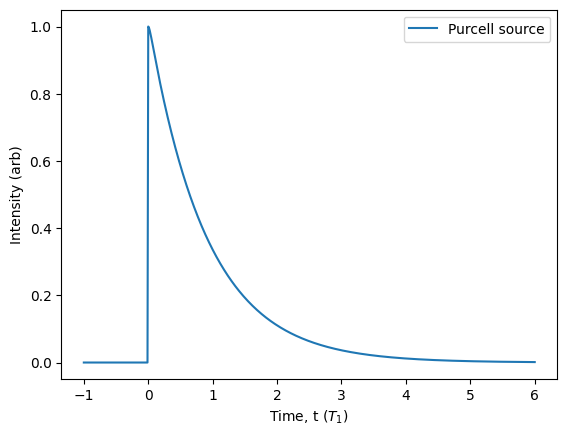

In [7]:
source.plot_lifetime(scale=10, start=-1, end=6, label='Purcell source').show()

## Using Purcell keywords

To help easily set up a Purcell source with the right characteristics, the class method has three keywords: 'purcell_factor', 'regime', and 'timescale'. Together, these three keywords fix the important decay rate and cavity coupling that determines the qualitative behaviour of the system. Using these keyword parameters, let's now make a purcell() source with a Purcell factor of 10, a timescale of 1, and that is excited by a Gaussian pulse. To see the impact of the regime keyword, we can plot the lifetime for three different regimes: strong coupling, critical coupling, and weak coupling.

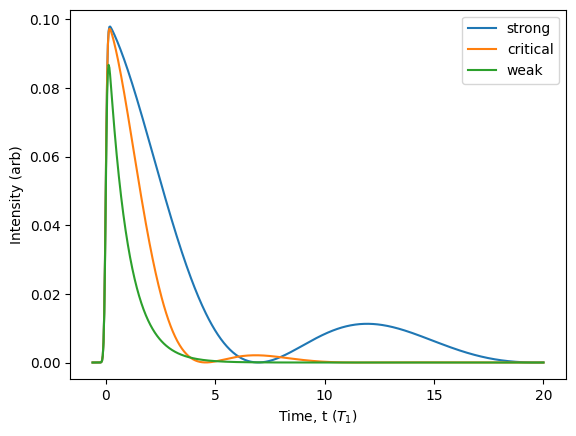

In [8]:
pulse = Pulse.gaussian()
source = Source.purcell(pulse=pulse, purcell_factor=10, timescale=1)
for x in [[2, 'strong'], [1, 'critical'], [0.1, 'weak']]:
    plot = source.plot_lifetime(parameters={'regime': x[0]}, end=20, label=x[1])
plot.show()

For a fixed source timescale, we can see that moving into the strong coupling regime will actually reduce the Purcell enhancement, which is again a manifestation of Purcell saturation. In addition, there is a pronounced revival in the emission due to the vacuum Rabi oscillations induced between the emitter and cavity. Each of these regimes also give rise to different source quality in terms of brightness, single-photon purity, and indistinguishability. Using the methods available from the SourceComponent class, we can easily explore these different characteristics.

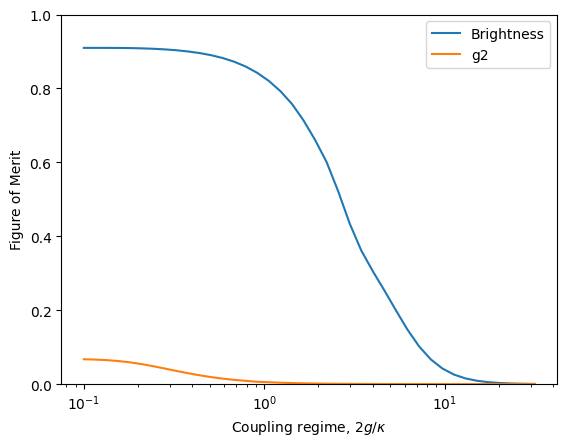

In [9]:
regime_list = np.logspace(-1, 1.5, 40)
beta_list = [source.beta(parameters={'regime': x}) for x in regime_list]
g2_list = [source.g2(parameters={'regime': x}) for x in regime_list]
plt.semilogx(regime_list, beta_list, label='Brightness')
plt.semilogx(regime_list, g2_list, label='g2')
plt.ylim([0, 1])
plt.legend()
plt.xlabel('Coupling regime, $2g/\kappa$')
plt.ylabel('Figure of Merit')
plt.show()

From this plot, we can clearly see the effect of Purcell saturation on the source brightness. As we move into the strong coupling regime, the vacuum Rabi oscillations prolong the interaction between the light and the emitter, allowing for more time for the light to escape via spontaneous emission and thus reducing the amount of light collection from the cavity mode. However, we can also see a very interesting effect on the single-photon purity. Moving toward the strong coupling regime can substantially suppress multi-photon emission.

## Overcoming dephasing

In addition to providing an enhanced collection efficiency, the acceleration of emission due to the cavity can also improve indistinguishability. The presence of the cavity will open a new decay channel that can extract photons from the emitter before interactions with the environment can degrade the quantum coherence of the emitter. To see this effect, let's look at adding a 'dephasing' value to the emitter in our PurcellSource object. To make a nice comparison, we must fix the emitter decay rate relative to the dephasing rate. To do this, we can specify the `timescale' to be 1/purcell_factor so that $\gamma = 1$.

Let's consider a pure dephasing rate of $\gamma^\star = 2\gamma$ and use a Gaussian excitation pulse with a width of $\tau = 0.004/\gamma$. For example, if the bare lifetime of the emitter was 1 nanosecond, the pulse width is 4 picoseconds. Now, we can loop over a changing Purcell factor and generate the source figures of merit.

In [10]:
source = Source.purcell(pulse=Pulse.gaussian({'width': 0.004}),
                        regime=0.1, parameters={'emitter/dephasing': 2})
purcell_list = np.logspace(-1, 1.5, 20)
M_list = [source.hom(parameters={'purcell_factor': x, 'timescale': 1/x},
                     pseudo_limit=0.1)['M'] for x in purcell_list]
g2_list = [source.g2(parameters={'purcell_factor': x, 'timescale': 1/x},
                     pseudo_limit=0.1) for x in purcell_list]
beta_list = [source.beta(parameters={'purcell_factor': x, 'timescale': 1/x}) for x in purcell_list]

Plotting this, we have:

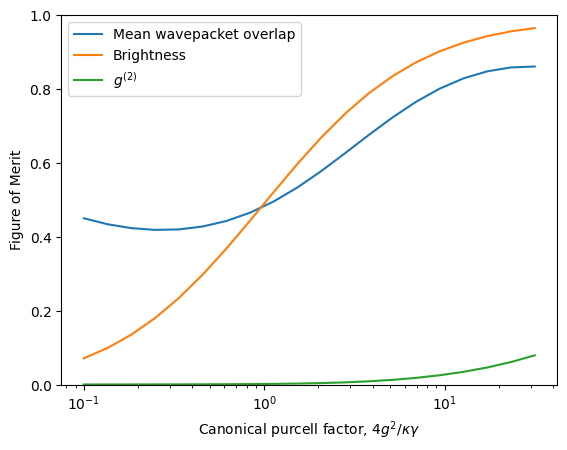

In [11]:
plt.semilogx(purcell_list, M_list, label='Mean wavepacket overlap')
plt.semilogx(purcell_list, beta_list, label='Brightness')
plt.semilogx(purcell_list, g2_list, label='$g^{(2)}$')
plt.ylim([0, 1])
plt.legend()
plt.xlabel('Canonical purcell factor, $4g^2/\kappa\gamma$')
plt.ylabel('Figure of Merit')
plt.show()

From this plot, we can see that increasing the Purcell factor improves the mean wavepacket overlap, which quantifies indistinguishability, in addition to improving the source brightness. Without a cavity, we would expect a mean wavepacket overlap of at most $M = \gamma/(\gamma+\gamma^\star) = 1/3$. With a cavity, we can exceed 80%. However, for a fixed pulse width, we can also see that the multiphoton emission is increased. This is because the Purcell effect decreases the effective lifetime of the source and makes it more likely that the pulse will cause re-excitation. This increasing $g^{(2)}$ causes the mean wavepacket overlap to saturate instead of increasing arbitrarily to 1.

The $g^{(2)}$ problem can be compensated by decreasing the pulse width. However, this requires a more intense laser pulse, which in turn makes it more difficult to filter out the single photon. In summary, the presence of a cavity can help improve indistinguishability and brightness, but in practice it cannot arbitrarily improve the source figures of merit.